In [1]:
import sys
sys.path.append("..")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from PDE_Net import DeepONet_NS, FNO2d, weight_init
from utils.DataGenerate_FNO import Dataset, Normalize, InNormalize, get_file
from torch.utils.tensorboard import SummaryWriter
from utilities3 import *

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
modes = 12
width = 100
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

epochs = 1000
step_size = 50

batch_size = 96
learning_rate = 0.001
iterations = 2*epochs
max_norm = 5

n_train = 300
n_test = 100

path = r'I:\ML\工况合集\5训练集-0.5m窗口-split2（base）\FNO\trained_model'
test_distance = np.load(r'I:\ML\工况合集\data\data_test\test_distance_data.npy')
test_label = np.load(r'I:\ML\工况合集\data\data_test\test_label.npy')
# test_data = np.load(r'truth_test.npy')
test_distance = torch.Tensor(test_distance)
test_label = torch.Tensor(test_label)
print(test_distance.shape)
print(test_label.shape)

torch.Size([96, 51, 51, 3])
torch.Size([96, 51, 51, 1])


In [9]:
x_normalizer_test = GaussianNormalizer(test_distance)
x_test = x_normalizer_test.encode(test_distance)
y_normalizer_test = GaussianNormalizer(test_label)
y_test = y_normalizer_test.encode(test_label)

# x_data = test_distance
# y_data = test_label

In [10]:
model = FNO2d(modes,modes,width)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
myloss = nn.MSELoss()

file_list = os.listdir(path)
if len(file_list) > 0:
	last_model = get_file(path)[-1]

# writer = SummaryWriter(r'runs\transtant_model')
begin_epoch = 0

In [11]:
file_list = os.listdir(path)
if len(file_list) > 0:
	last_model = get_file(path)[-1]
save_path = last_model
# save_path = r'I:\ML\Package_model\DeepONet\FNO_distance\trained_model\FNO_distance_width_100_inout_5000_time_model_input3.pth'
begin_epoch = load_model(save_path, optimizer, model)
model.to(device)

Load model at epoch: 900


FNO2d(
  (p): Linear(in_features=5, out_features=100, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (w0): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(100, 100, kernel_size=(1, 1), stride=(1,

In [12]:
# dataset = Dataset(data_dir,is_pred=False,split=2,is_save=False,datafile=datafile)
# data_x, data_y = dataset.getitem()
# print(data_x.shape)
# data_x, mean_x, std_x = Normalize(data_x)
# data_y, mean_y, std_y = Normalize(data_y)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(torch.utils.data.TensorDataset(train_data, truth_data), batch_size=batch_size, shuffle=True)
x, y = next(iter(test_loader))
print(torch.max(x))
print(torch.max(y))

tensor(4.0281)
tensor(4.0281)


In [14]:

pred = torch.empty((0,96,51,51,2)).to(device)
model.eval()
with torch.no_grad():
	for batch_test in test_loader:

		loss_test = 0
		test_x,test_y = batch_test

		test_x = test_x.float().to(device)			# [length,time_step,51,51,3]
		test_y = test_y.float().to(device)			# [length,time_step,51,51,3]

		pred_test = model(x)												# x:[length,51,51,3], pred:[length,51,51,3]

		pred_test = y_normalizer_test.decode(pred_test)
		test_y = y_normalizer_test.decode(test_y)

		loss_test = myloss(pred_test.clone(), test_y.clone())
print(pred_test.shape)
print(loss_test)

torch.Size([96, 51, 51, 1])
tensor(0.0177, device='cuda:0')


(96, 51, 51, 1)


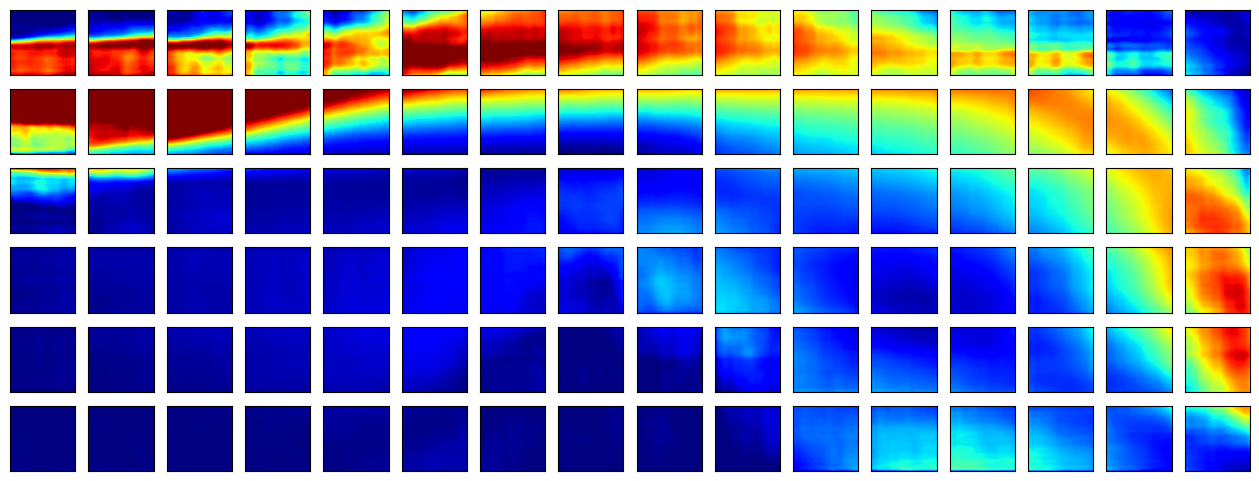

In [17]:
# pred = train_normalizer.decode(pred)
test_x = pred_test.cpu().detach().numpy()
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[n_y-1-i,j].contourf(coordinate[0], coordinate[1], test_x[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[n_y-1-i,j].set_aspect('equal')
		axs[n_y-1-i,j].set_xticks([])
		axs[n_y-1-i,j].set_yticks([])


plt.show()

(96, 51, 51, 1)


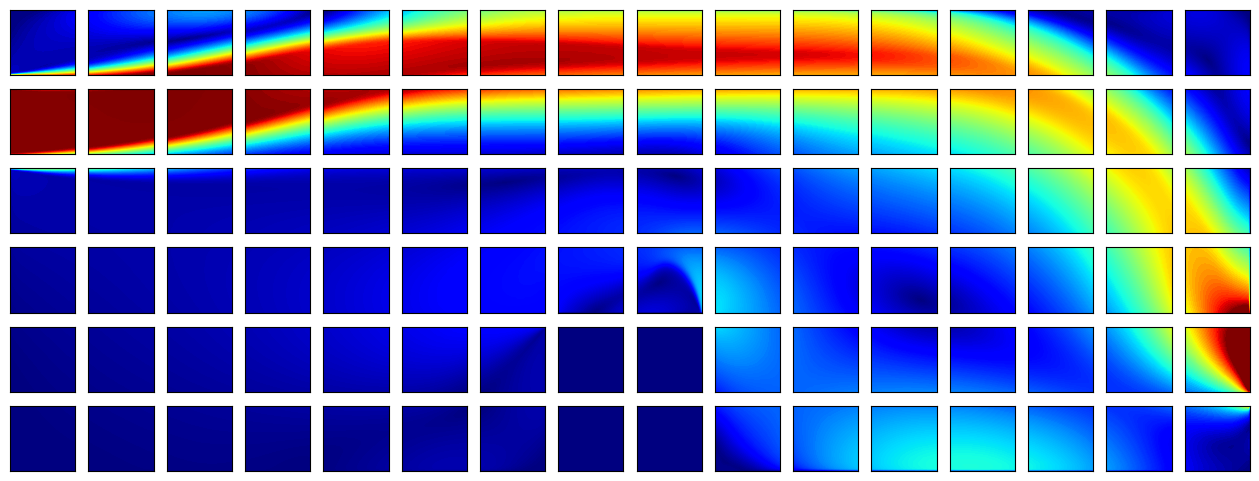

In [21]:
# 真实结果
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(test_x.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[n_y-1-i,j].contourf(coordinate[0], coordinate[1], test_label[i+j*n_y,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[n_y-1-i,j].set_aspect('equal')
		axs[n_y-1-i,j].set_xticks([])
		axs[n_y-1-i,j].set_yticks([])


plt.show()

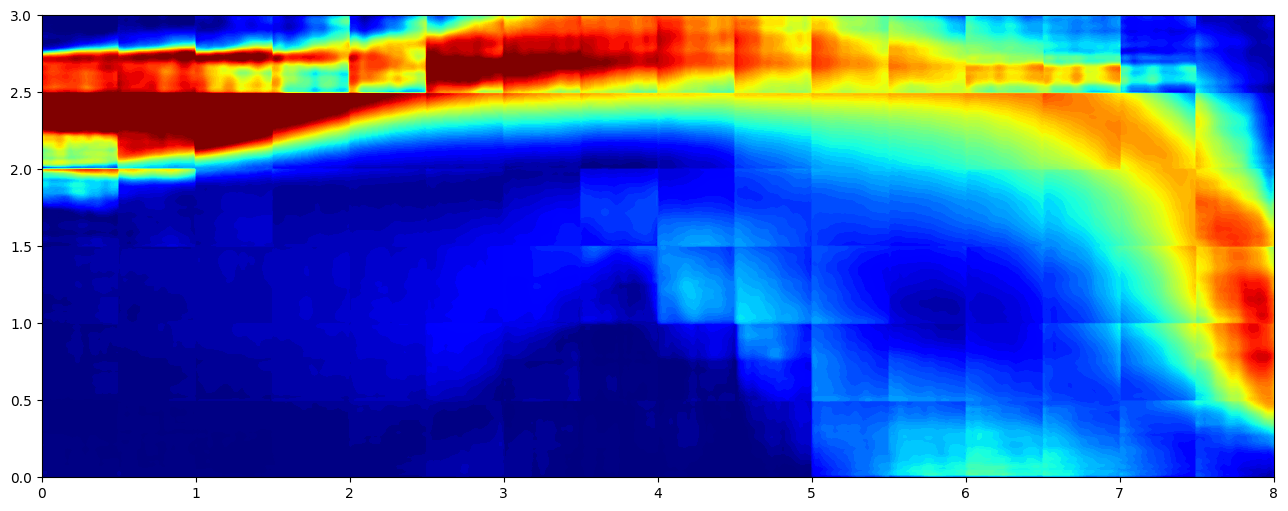

In [18]:
all_zone = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == (n_y-1) and j != (n_x-1):
			all_zone[-p_x:,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*n_y,:,:,0]
		elif i != (n_y-1) and j == (n_x-1):
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,-p_y:] = test_x[i+j*n_y,:,:,0]
		elif i == (n_y-1) and j == (n_x-1):
			all_zone[-p_x:,-p_y:] = test_x[i+j*n_y,:,:,0]
		else:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = test_x[i+j*n_y,:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28380\314474411.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(x, y, z, kind='cubic')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28380\314474411.py:15: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev`

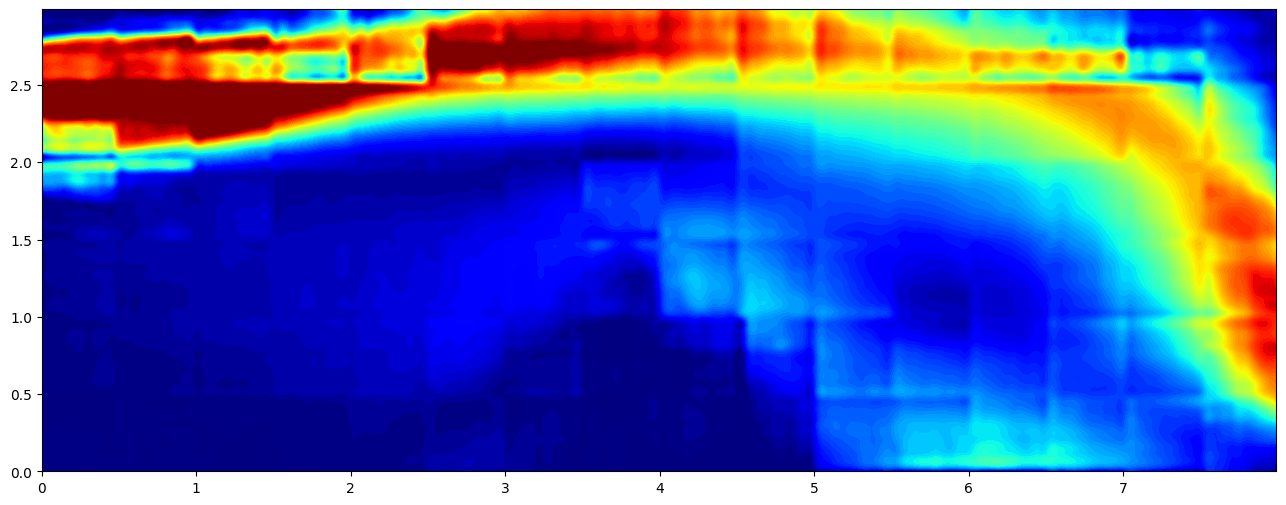

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

interval = 5
x = np.linspace(0, 8, int(800/interval))
y = np.linspace(0, 3, int(300/interval))
xx, yy = np.meshgrid(x, y) #建立原始坐标
z = all_zone[::interval,::interval]

f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)
znew = f(xnew, ynew) #插值后的数据


fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(xnew,ynew,znew,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

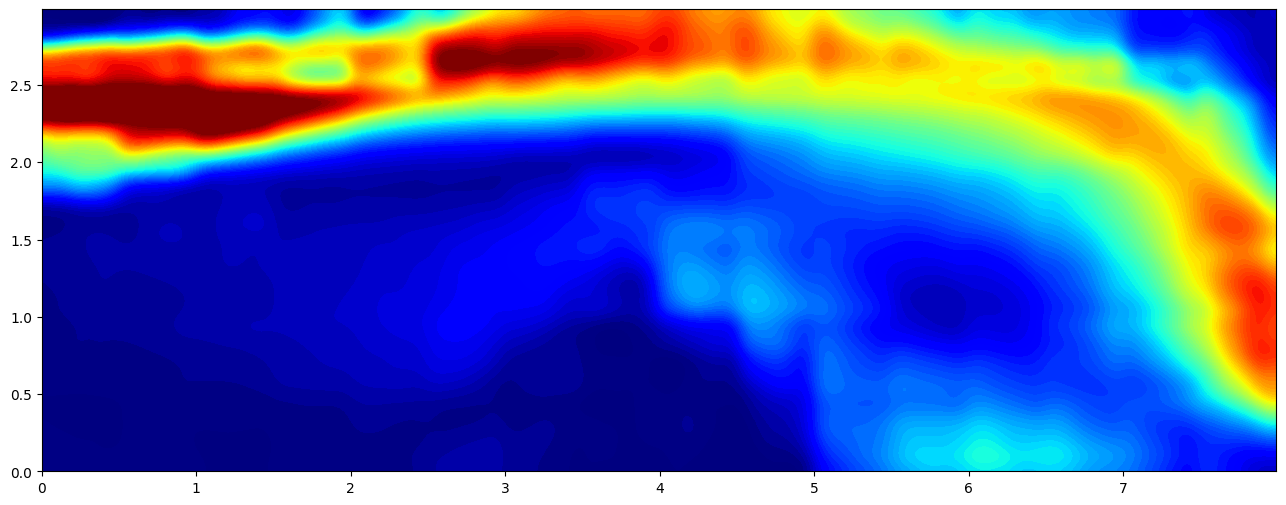

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2

# 准备数据集
data = all_zone  # 二维矩阵，形状为 (300, 800)

# 中值滤波
# smoothed_data = medfilt2d(data, kernel_size=9)

# 高斯加权平均滤波
sigma = 6  # 高斯滤波的标准差
smoothed_data = gaussian_filter(data, sigma=sigma)

# 移动平均法滤波处理
# window_size = 20  # 移动平均窗口的大小
# kernel = np.ones((window_size, window_size)) / (window_size**2)
# smoothed_data = convolve2d(data, kernel, mode='same')

# 加权平均法滤波处理
# weights = np.array([[1, 2, 1],
#                     [2, 10, 2],
#                     [1, 2, 1]])  # 加权平均的权重矩阵
# weights = weights / np.sum(weights)  # 归一化权重矩阵
# smoothed_data = convolve2d(data, weights, mode='same')

# Savitzky-Golay滤波处理
# window_size = 50  # 滤波窗口的大小
# poly_order = 2  # 多项式拟合的阶数
# smoothed_data = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# 傅里叶变换
# f_data = fft2(data)

# # 频域滤波（在此示例中，假设我们想去除低频分量，保留高频分量）
# cutoff = 1  # 截止频率
# f_data[np.abs(f_data) < cutoff] = 0

# # 逆傅里叶变换
# smoothed_data = np.real(ifft2(f_data))

# 绘制等高线图
xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(xnew,ynew,smoothed_data,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

### 用DeepONet重构结果

In [107]:
DNO_repred_data = test_x
bc_left = DNO_repred_data[:, :, 0, :]
bc_right = DNO_repred_data[:, :, -1, :]
bc_top = DNO_repred_data[:, -1, :, :]
bc_bottom = DNO_repred_data[:, 0, :, :]
bc = np.concatenate((bc_left, bc_top, bc_right, bc_bottom), axis=1)
DON_model = DeepONet_NS([204, 512, 512, 512, 512, 512], [2, 16, 64, 256, 512, 512, 512])
DON_optimizer = optim.Adam(DON_model.parameters(), lr=learning_rate, weight_decay=1e-4)
DON_save_path = r'I:\ML\Package_model\DeepONet\original_model\trained_model\original_DON_48000_4000.pth'
saved_epoch = load_model(DON_save_path, DON_optimizer, DON_model)

Load model at epoch: 4000


In [108]:
coordinate = np.meshgrid(np.linspace(0,0.5,51),np.linspace(0,0.5,51))
coordinate = np.stack(coordinate, axis=-1).reshape(-1,2)
print(bc.shape)
print(coordinate.shape)

(96, 204, 1)
(2601, 2)


In [109]:
DON_model.to(device)
DON_pred = DON_model(torch.Tensor(bc[...,0]).to(device), torch.Tensor(coordinate).to(device))
DON_pred = DON_pred.cpu().detach().numpy()

(96, 51, 51, 1)


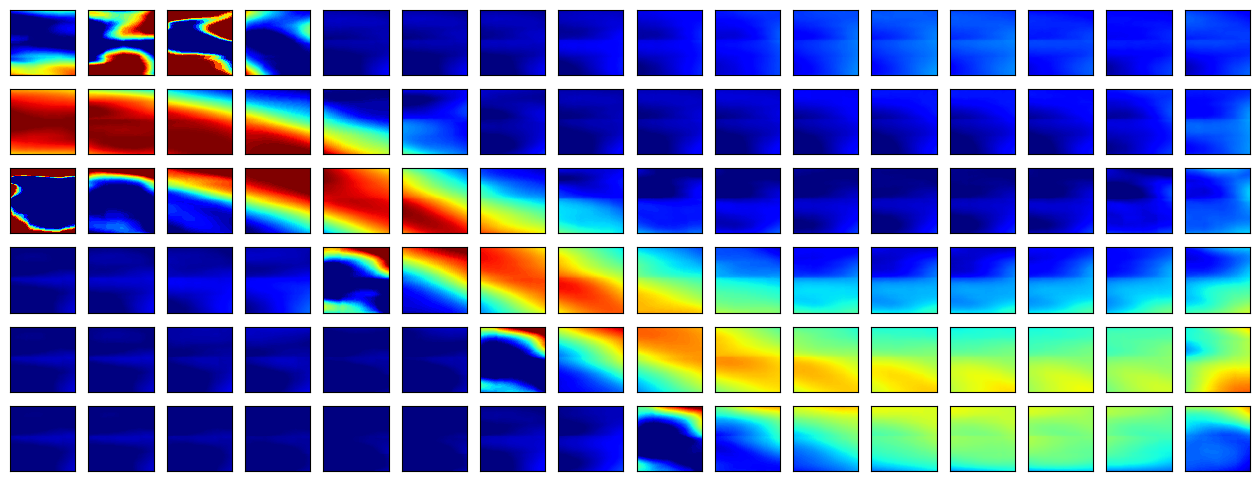

In [110]:
DON_pred = DON_pred.reshape(-1,51,51,1)
coordinate = np.meshgrid(np.linspace(0,0.5,51),np.linspace(0,0.5,51))
fig,axs = plt.subplots(6,16,figsize=(16,6))
print(DON_pred.shape)
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], DON_pred[i+j*6,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])


plt.show()

Locator attempting to generate 9378 ticks ([-2.934, ..., 11.131499999999999]), which exceeds Locator.MAXTICKS (1000).


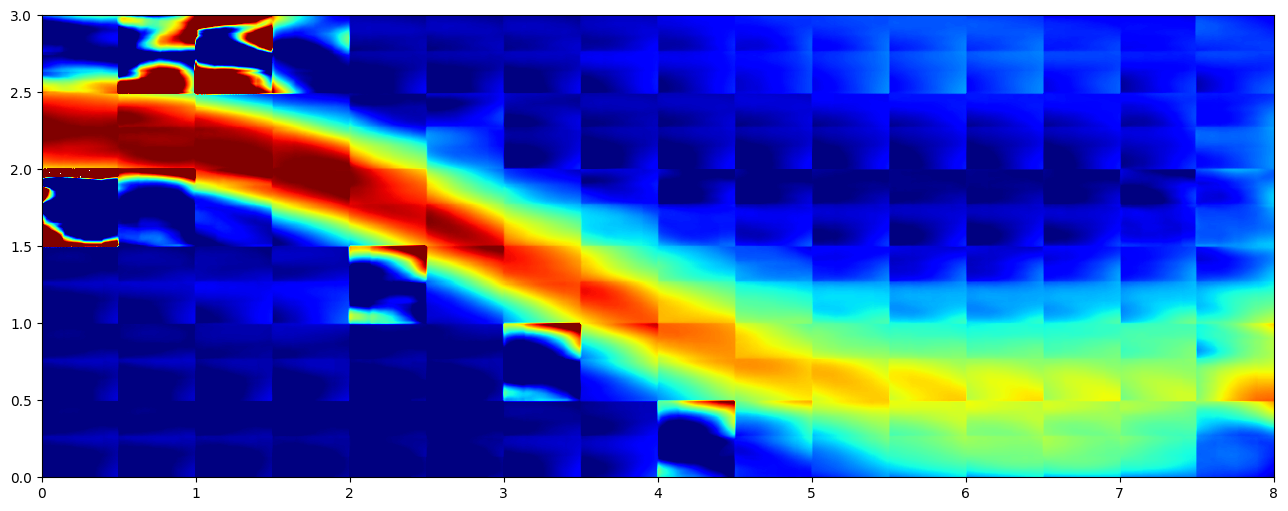

In [111]:
all_zone_DNO = np.zeros((300,800))
for i in range(6):
	for j in range(16):
		if i == 5 and j != 15:
			all_zone_DNO[-51:,j*50:(j+1)*50+1] = DON_pred[i+j*6,:,:,0]
		elif i != 5 and j == 15:
			all_zone_DNO[i*50:(i+1)*50+1,-51:] = DON_pred[i+j*6,:,:,0]
		elif i == 5 and j == 15:
			all_zone_DNO[-51:,-51:] = DON_pred[i+j*6,:,:,0]
		else:
			all_zone_DNO[i*50:(i+1)*50+1,j*50:(j+1)*50+1] = DON_pred[i+j*6,:,:,0]

fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone_DNO,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

Locator attempting to generate 8777 ticks ([-1.6602000000000001, ..., 3.6054]), which exceeds Locator.MAXTICKS (1000).


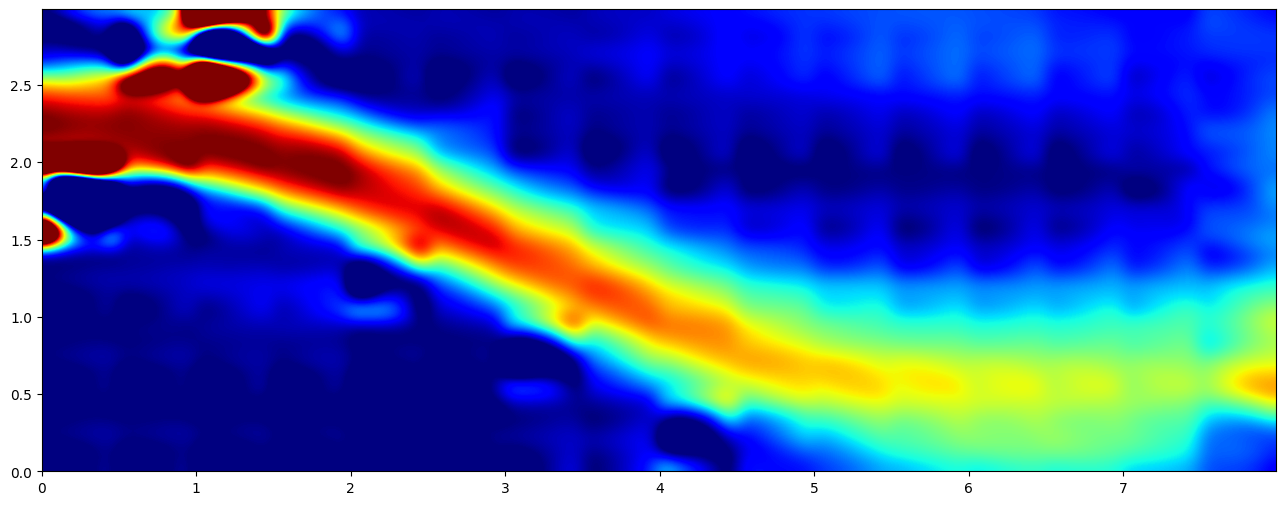

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2

# 准备数据集
data = all_zone_DNO  # 二维矩阵，形状为 (300, 800)

# 中值滤波
# smoothed_data = medfilt2d(data, kernel_size=9)

# 高斯加权平均滤波
sigma = 6  # 高斯滤波的标准差
smoothed_data = gaussian_filter(data, sigma=sigma)

# 移动平均法滤波处理
# window_size = 20  # 移动平均窗口的大小
# kernel = np.ones((window_size, window_size)) / (window_size**2)
# smoothed_data = convolve2d(data, kernel, mode='same')

# 加权平均法滤波处理
# weights = np.array([[1, 2, 1],
#                     [2, 10, 2],
#                     [1, 2, 1]])  # 加权平均的权重矩阵
# weights = weights / np.sum(weights)  # 归一化权重矩阵
# smoothed_data = convolve2d(data, weights, mode='same')

# Savitzky-Golay滤波处理
# window_size = 50  # 滤波窗口的大小
# poly_order = 2  # 多项式拟合的阶数
# smoothed_data = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# 傅里叶变换
# f_data = fft2(data)

# # 频域滤波（在此示例中，假设我们想去除低频分量，保留高频分量）
# cutoff = 1  # 截止频率
# f_data[np.abs(f_data) < cutoff] = 0

# # 逆傅里叶变换
# smoothed_data = np.real(ifft2(f_data))

# 绘制等高线图
xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(xnew,ynew,smoothed_data,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

(96, 51, 51, 1)


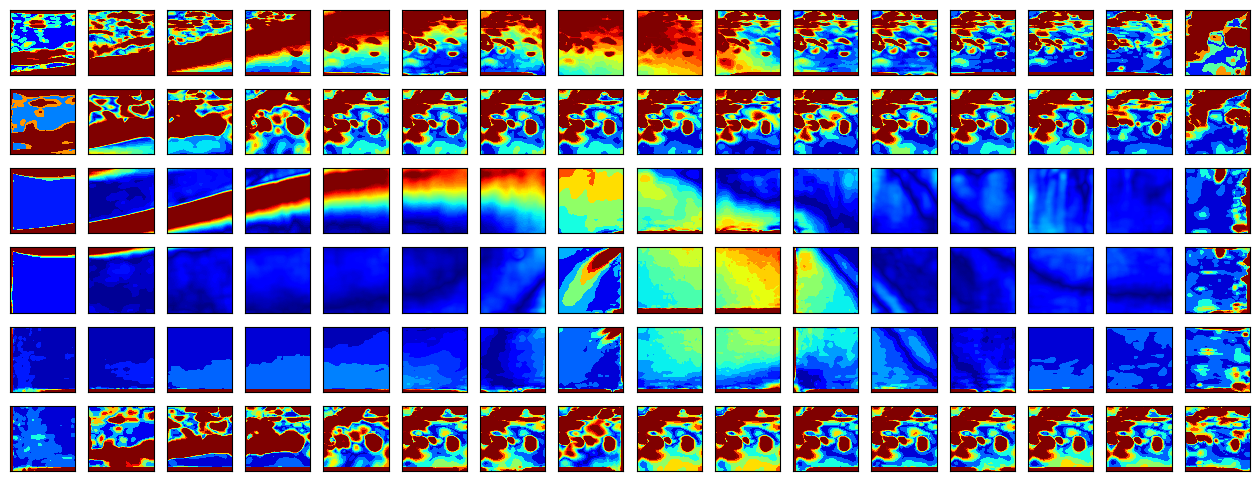

In [13]:
def solve_velocity(vorticity):
    # 计算速度场的分量 u = ∂ψ/∂y，v = -∂ψ/∂x
    u = np.gradient(-vorticity, axis=1)
    v = np.gradient(vorticity, axis=0)

    return u, v

# 求解速度场
u, v = solve_velocity(test_x)
mag = np.sqrt(u**2 + v**2)
print(mag.shape)
# 绘制速度场
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], mag[i+j*6,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])


plt.show()

(96, 51, 51, 1)


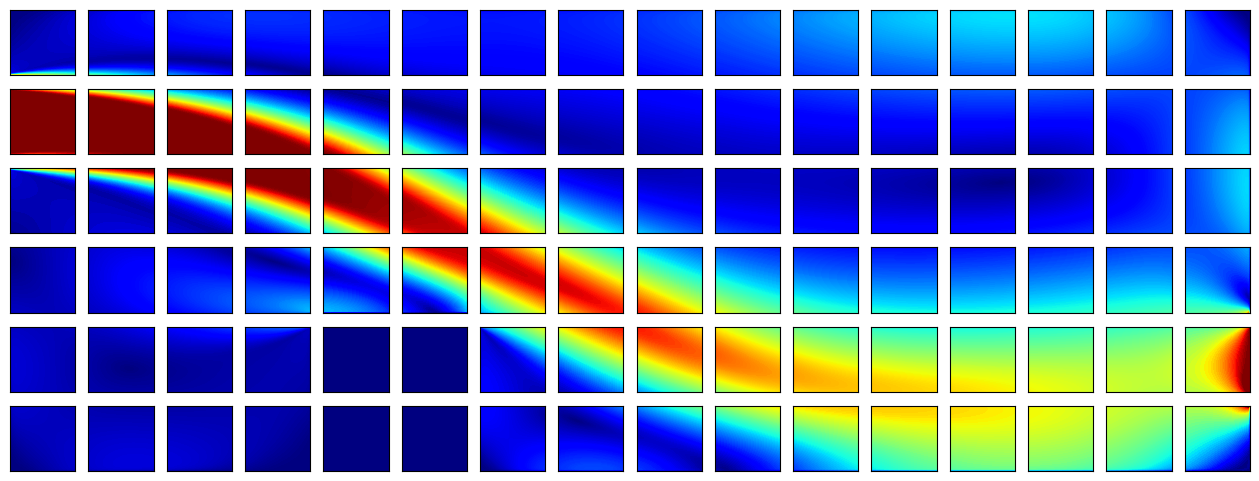

In [20]:
train_data = train_data.cpu().detach().numpy()

coordinate = np.meshgrid(np.linspace(0,0.5,51),np.linspace(0,0.5,51))
fig,axs = plt.subplots(6,16,figsize=(16,6))
print(train_data.shape)
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], train_data[i+j*6,:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])


plt.show()

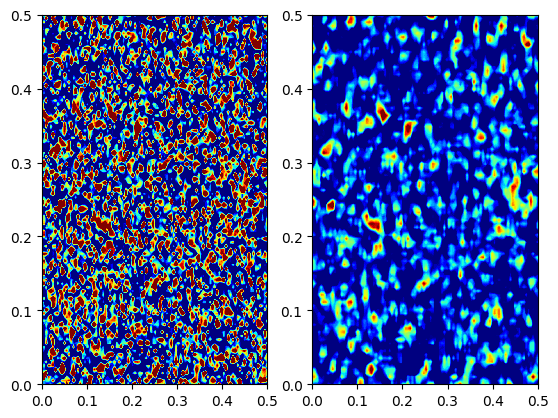

In [60]:
import numpy as np
import scipy.ndimage as ndimage

# 定义速度分布矩阵
velocity = np.random.randn(100, 100)
coordinate = np.meshgrid(np.linspace(0,0.5,100),np.linspace(0,0.5,100))
fig,axs = plt.subplots(1,2)
axs[0].contourf(coordinate[0], coordinate[1], velocity, 100, cmap='jet', vmin=0, vmax=1)

# 定义平滑窗口大小
window_size = 3

# 使用移动平均滤波器进行平滑处理
smoothed_velocity = ndimage.uniform_filter(velocity, size=window_size)

# 打印平滑后的速度分布矩阵
# print(smoothed_velocity)

axs[1].contourf(coordinate[0], coordinate[1], smoothed_velocity, 100, cmap='jet', vmin=0, vmax=1)


In [23]:
coordinate = np.meshgrid(np.linspace(0,0.5,51), np.linspace(0,0.5,51))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)
print(coordinate.shape)

(2601, 2)
